# Model training

In [11]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pdS
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

import time

import data_reader
import dataset

from train_util import fwd_pass, train, test

In [12]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [13]:
# Training and data variables

MODE = "w"
EXP_NAME = "ejemplo_1"

DATA_SET_NAME = f"data_set_x20_100%_split"
PATCH_SIZE = 512

BATCH_SIZE = 8
EPOCHS = 10

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

In [14]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    net = torchvision.models.resnet18(pretrained=True).to(device)
    
    for param in net.parameters():
        param.requires_grad = False # Freezing the convolutional layers
    
    for param in net.layer4[1].parameters():
        param.requires_grad = True # Unfreezing the last residual block

    
    net.fc = nn.Sequential(
                nn.Linear(512, 2),
                #nn.ReLU(inplace=True),
                #nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

    net.fc.apply(init_weights) # Xavier init

    #print(f"Loading {MODEL_NAME}")
    # net.fc = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    print("Number of free parameters: ", n_params)

    #Hyperparameters:
    learning_rate = 1E-4 # LR
    loss_function = nn.BCELoss()  # Loss # [1,0] es positivo y [0,1] negativo
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer
    lambda1 = lambda epoch: 1 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i]/255) # Np array

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    y_pred = [torch.argmin(i) for i in outputs.cpu()] # 1 means positive diagnosis: (1,0) => 1
    y_true = [torch.argmin(i) for i in y.cpu()]
    conf_m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)


    """
    for i, x in enumerate(X):
        plt.xlabel(f"Label: {y_true[i]} Predicted: {y_pred[i]} Output: {outputs[i].cpu().detach().numpy()}")
        plt.imshow(X[i].permute(2, 1, 0).cpu())
        plt.show()
    print(conf_m)
    """
    
    if train:
        loss.backward() # Calculate gradients using backprop
        optimizer.step() # Updates W and b using previously calculated gradients

    return acc, loss, conf_m

In [7]:
def train():
  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME, EPOCHS
  
  print(MODEL_NAME)

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss = 0, 0,
      val_acc, val_loss = 0, 0,
      conf_m, val_conf_m = np.array([[0,0],[0,0]]), np.array([[0,0],[0,0]])

      print("\nEPOCH: ", epoch+1)

      for batch_X, batch_y in tqdm(iter(train_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux*(len(batch_X)/len(train_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/len(train_set))
        conf_m += conf_m_aux

        """
        i += 1
    
        if i%100 == 0:
          print("Memory allocated in GPU: ", torch.cuda.memory_allocated("cuda:0")/1024/1024/1024)
        """
        
      for batch_X, batch_y in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          acc_aux, loss_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=False)

        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc trough batches
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux

      acc = (conf_m[0][0]+conf_m[1][1])/(conf_m[1][0]+conf_m[0][1]+conf_m[1][1]+conf_m[0][0]) # Better way to obtain acc tan using per batch acc
      val_acc = (val_conf_m[0][0]+val_conf_m[1][1])/(val_conf_m[1][0]+val_conf_m[0][1]+val_conf_m[1][1]+val_conf_m[0][0])

      prc = conf_m[1][1]/(conf_m[1][1]+conf_m[0][1])
      val_prc = val_conf_m[1][1]/(val_conf_m[1][1]+val_conf_m[0][1])
      rec = conf_m[1][1]/(conf_m[1][1]+conf_m[1][0])
      val_rec = val_conf_m[1][1]/(val_conf_m[1][1]+val_conf_m[1][0])
      f1 = 2*prc*rec/(prc+rec)
      val_f1 = 2*val_prc*val_rec/(val_prc+val_rec)
      
      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")
      print("Val PRC:", val_prc, "Train PRC: ", prc) # TP/TP+FP
      print("Val REC: ", val_rec,"Train REC: ", rec) # TP/TP+FN
      print("Val f1: ", val_f1," Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m,"\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(prc),4)},{round(float(rec),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_prc),4)}, {round(float(val_rec),4)}\n")
      f.write("\n\n")

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")



CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
def test():
  global test_set, test_dataloader, MODEL_NAME, MODE

  with open(r"C:\Users\Alejandro\Desktop\heterogeneous-data\results\WSI\test.csv", MODE) as f:
    acc, loss = 0, 0
    conf_m = np.array([[0,0],[0,0]])
    for batch_X, batch_y in tqdm(iter(test_dataloader)):
      batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

      net.eval() # Making sure that the model is not training and deactivate droptout

      with torch.no_grad(): # Disable all computations, works together with net.eval()
          acc_aux, loss_aux, conf_m_aux = fwd_pass(batch_X, batch_y, train=False)

      acc += acc_aux*(len(batch_X)/len(test_set)) # Calculating the average loss and acc trough batches
      loss += loss_aux*(len(batch_X)/len(test_set))
      conf_m += conf_m_aux

    prc = conf_m[0][0]/(conf_m[0][0]+conf_m[0][1])
    rec = conf_m[0][0]/(conf_m[0][0]+conf_m[0][1])
    f1 = 2*prc*rec/(prc+rec)

    print("Test loss: ", loss.item(), "\n")
    print("Test acc: ", acc, "\n")
    print("Test PRC: ", prc, "\n") # TP/TP+FP
    print("Test REC: ", rec, "\n") # TP/TP+FN
    print("f1: ", f1, "\n")
    print("\nCONF: \n", conf_m, "\n")

In [8]:
# Choosing only the images from the according splits (10CV)

SPLITS = 1 # Number of iterations > n_splits
n_splits = 10 # Number of splits to use

for SPLIT in range(SPLITS):
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits: # For the final split for validation we take the firs one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)

    # Random oversampler

    y =  [i[0] for i in train_set.labels]
    positive = sum(y)
    class_sample_count = np.array([len(y)-positive ,positive])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))#, replacement=False)
    # Will take len(samples_weight) number of samples, this can be changed
    
    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    # Loading validation splits:
    if SPLIT == n_splits:
        SPLIT_NAME = DATA_SET_NAME + f"{0}"
        print(f"Loading test split: {0}")
    else:
        SPLIT_NAME = DATA_SET_NAME + f"{SPLIT+1}"
        print(f"Loading test split: {SPLIT+1}")

    X_, y_, _ , _ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/patches/{SPLIT_NAME}")

    test_set.inputs.extend(X_)
    test_set.labels.extend(y_)

    test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for test: {len(test_set)}\n")

    init()

    train()

    del train_set, val_set, test_set


Loading training split: 2
Read lmdb
Loading training split: 3
Read lmdb
Loading training split: 4
Read lmdb
Loading training split: 5
Read lmdb
Loading training split: 6
Read lmdb
Loading training split: 7
Read lmdb
Loading training split: 8
Read lmdb
Loading training split: 9
Read lmdb
Patches for training: 118075

Loading validation split: 0
Read lmdb
Patches for validation: 16928

Loading test split: 1
Read lmdb
Patches for test: 13812

Number of free parameters:  1026
ejemplo_2_0

EPOCH:  1


  0%|          | 0/14760 [00:00<?, ?it/s]

c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


  0%|          | 0/2116 [00:00<?, ?it/s]

0.9926748582230623
0.9737624391276731
Val loss:  0.023938510566949844  Train loss:  0.0765271857380867 

Val acc:  0.992674858223018  Train acc:  0.9737624391277412 

Val PRC: 0.9543021819678881 Train PRC:  0.9732656400222646
Val REC:  0.9944229944229944 Train REC:  0.9744490416279659
Val f1:  0.9739495798319329  Train f1:  0.973856981316771 

Val CONF: 
 [[14486   111]
 [   13  2318]] 
Train CONF: 
 [[57275  1585]
 [ 1513 57702]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9965146502835539
0.9884564895193733
Val loss:  0.01064819935709238  Train loss:  0.03605412319302559 

Val acc:  0.9965146502835064  Train acc:  0.9884564895194378 

Val PRC: 0.9883920894239037 Train PRC:  0.9885039956657186
Val REC:  0.9862719862719863 Train REC:  0.9884203219963094
Val f1:  0.9873308997208504  Train f1:  0.9884621570602626 

Val CONF: 
 [[14570    27]
 [   32  2299]] 
Train CONF: 
 [[58327   679]
 [  684 58385]] 

Learning Rate:  0.0001

EPOCH:  3


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9910207939508506
0.9931230150328181
Val loss:  0.027970707044005394  Train loss:  0.021828286349773407 

Val acc:  0.9910207939508071  Train acc:  0.9931230150328814 

Val PRC: 0.9500206526228832 Train PRC:  0.9926333930321359
Val REC:  0.9867009867009867 Train REC:  0.9936406995230525
Val f1:  0.9680134680134681  Train f1:  0.9931367908580702 

Val CONF: 
 [[14476   121]
 [   31  2300]] 
Train CONF: 
 [[58513   436]
 [  376 58750]] 

Learning Rate:  0.0001

EPOCH:  4


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9909617202268431
0.9943679864492907
Val loss:  0.030567621812224388  Train loss:  0.017599260434508324 

Val acc:  0.9909617202268005  Train acc:  0.9943679864493531 

Val PRC: 0.9587194608256108 Train PRC:  0.9943316814880184
Val REC:  0.9764049764049764 Train REC:  0.994382308514791
Val f1:  0.967481402763018  Train f1:  0.9943569943569943 

Val CONF: 
 [[14499    98]
 [   55  2276]] 
Train CONF: 
 [[58820   334]
 [  331 58590]] 

Learning Rate:  0.0001

EPOCH:  5


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.994210775047259
0.9961465170442515
Val loss:  0.021493416279554367  Train loss:  0.012130554765462875 

Val acc:  0.9942107750472131  Train acc:  0.9961465170443122 

Val PRC: 0.9749042960442365 Train PRC:  0.9959481910961924
Val REC:  0.9832689832689833 Train REC:  0.9963366857181623
Val f1:  0.9790687740281931  Train f1:  0.9961424005290422 

Val CONF: 
 [[14538    59]
 [   39  2292]] 
Train CONF: 
 [[58873   239]
 [  216 58747]] 

Learning Rate:  0.0001

EPOCH:  6


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9937381852551985
0.9967054838026678
Val loss:  0.01719295047223568  Train loss:  0.009510921314358711 

Val acc:  0.9937381852551536  Train acc:  0.9967054838027286 

Val PRC: 0.9595208591491119 Train PRC:  0.9966810431969809
Val REC:  0.9965679965679966 Train REC:  0.9967650081717242
Val f1:  0.9776936026936026  Train f1:  0.9967230239160285 

Val CONF: 
 [[14499    98]
 [    8  2323]] 
Train CONF: 
 [[58527   197]
 [  192 59159]] 

Learning Rate:  0.0001

EPOCH:  7


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9945061436672968
0.9973999576540334
Val loss:  0.017307402566075325  Train loss:  0.007887317799031734 

Val acc:  0.9945061436672514  Train acc:  0.9973999576540932 

Val PRC: 0.967809364548495 Train PRC:  0.9973665107956176
Val REC:  0.9931359931359931 Train REC:  0.9974507023230686
Val f1:  0.9803091255557909  Train f1:  0.9974086047826858 

Val CONF: 
 [[14520    77]
 [   16  2315]] 
Train CONF: 
 [[58687   156]
 [  151 59081]] 

Learning Rate:  0.0001

EPOCH:  8


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9969872400756143
0.9976116874867669
Val loss:  0.010818341746926308  Train loss:  0.007476171012967825 

Val acc:  0.9969872400755673  Train acc:  0.9976116874868266 

Val PRC: 0.9935064935064936 Train PRC:  0.997552536078994
Val REC:  0.9845559845559846 Train REC:  0.9976872562756386
Val f1:  0.9890109890109892  Train f1:  0.9976198916291082 

Val CONF: 
 [[14582    15]
 [   36  2295]] 
Train CONF: 
 [[58693   145]
 [  137 59100]] 

Learning Rate:  0.0001

EPOCH:  9


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9950968809073724
0.9981875926318018
Val loss:  0.01901698112487793  Train loss:  0.005709636025130749 

Val acc:  0.9950968809073261  Train acc:  0.9981875926318614 

Val PRC: 0.9824034334763948 Train PRC:  0.9981401640037196
Val REC:  0.9819819819819819 Train REC:  0.9982414312044505
Val f1:  0.9821926625187728  Train f1:  0.9981907950356768 

Val CONF: 
 [[14556    41]
 [   42  2289]] 
Train CONF: 
 [[58826   110]
 [  104 59035]] 

Learning Rate:  0.0001

EPOCH:  10


  0%|          | 0/14760 [00:00<?, ?it/s]

  0%|          | 0/2116 [00:00<?, ?it/s]

0.9959239130434783
0.9982553461782765
Val loss:  0.015226030722260475  Train loss:  0.005627742037177086 

Val acc:  0.9959239130434313  Train acc:  0.998255346178336 

Val PRC: 0.9808673469387755 Train PRC:  0.9982653651236353
Val REC:  0.9897039897039897 Train REC:  0.9982314128290593
Val f1:  0.9852658552210122  Train f1:  0.9982483886876521 

Val CONF: 
 [[14552    45]
 [   24  2307]] 
Train CONF: 
 [[59169   102]
 [  104 58700]] 

Learning Rate:  0.0001


In [ ]:
conf = [[ 1504, 3835],[ 1504, 14597]]

print((conf[0][0]+conf[1][1])/(conf[1][0]+conf[0][1]+conf[1][1]+conf[0][0]))

In [9]:
def learning_curve(NAME):
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{NAME}.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "CONF_M", "PRC", "REC",
                     "VAL_ACC", "VAL_LOSS", "VAL_CONF_M", "VAL_PRC", "VAL_REC"]

  fig, axs = plt.subplots(2, figsize=(5,7))

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{NAME}.pdf")

ejemplo_2_0


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_10080\3090359943.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


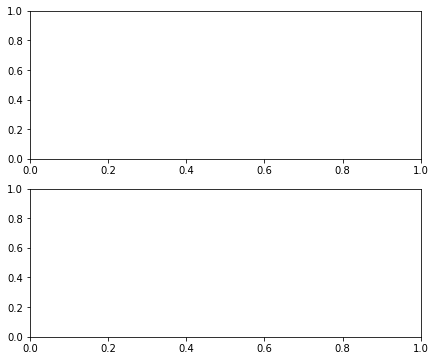

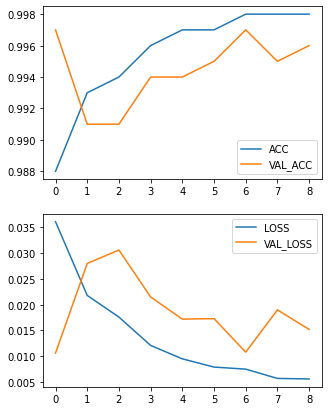

In [10]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve(NAME)